In [1]:
import sys
sys.path.append('../')

import gc
import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats

#from sa_decomp_layer import SADecompLayer



import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#tf.__version__
from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet152, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp
from glob import glob


from tensorflow.keras.utils import to_categorical
from tensorflow.data import Dataset, AUTOTUNE
from imagenet_utils.imagenet_clsloc2 import clsloc
from imagenet_utils.load_images import load_images
from imagenet_utils.preprocess import preprocess

from utils.utils import *

import keras
from keras import layers

from keras import backend as K

import scienceplots

from activation_maximization import showall, getAM

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

In [2]:
gc.collect()
model = VGG16(weights='imagenet',
				  include_top=True,
				  input_shape=(224, 224, 3))



In [3]:
LAYER = -3

In [4]:
top10KF = topKfilters(model, LAYER, k=20)   #Find the top 20% filters to look at
print(top10KF)

[104, 226, 344, 410, 413, 463, 23, 105, 54, 380, 98, 88, 216, 430, 42, 108, 176, 266, 317, 84, 241, 306, 465, 114, 483, 236, 45, 479, 392, 323, 170, 202, 37, 191, 394, 243, 156, 331, 313, 338, 332, 211, 209, 334, 80, 4, 41, 101, 111, 488, 268, 299, 74, 56, 433, 371, 302, 262, 55, 322, 247, 52, 414, 112, 205, 375, 169, 21, 492, 26, 301, 491, 425, 146, 428, 28, 57, 244, 242, 82, 328, 38, 321, 487, 183, 234, 117, 314, 231, 390, 455, 253, 456, 409, 311, 279, 424, 267, 427, 64, 166, 122]


In [5]:
conv_layers = []
for l in model.layers:
	if 'conv2d' in str(type(l)).lower():
		if l.kernel_size == (3,3):
			conv_layers.append(l)
			
layer_num = model.layers.index(conv_layers[LAYER])
layer_num_p = layer_num-1

In [6]:
F = 463
#top10KF[0]

In [7]:
origAM, scaledAM = getAM(model, LAYER, F )
modified_model = keras.models.Model(
	model.inputs, [model.layers[layer_num_p].output, model.layers[layer_num].output, model.output]
)

f2, f1, preds = modified_model(tf.expand_dims(origAM, axis=0), training=False)
f2_mean_act = tf.math.reduce_mean(f2, axis=(0,1,2))


block5_conv1


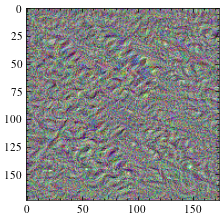

In [8]:

plt.imshow(tf.keras.utils.array_to_img(scaledAM))

In [9]:
f1.shape

TensorShape([1, 14, 14, 512])

In [10]:
f2_mean_act.shape

TensorShape([512])

<BarContainer object of 512 artists>

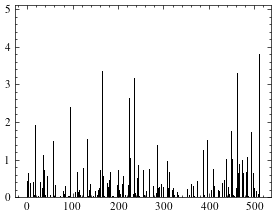

In [11]:

f2, f1, preds = modified_model(tf.expand_dims(origAM, axis=0), training=False)
f2_mean_act = tf.math.reduce_mean(f2, axis=(0,1,2))
f1_mean_act = tf.math.reduce_mean(f1, axis=(0,1,2))
plt.bar(list(range(512)), f1_mean_act)


(3, 3, 512, 512)
(512,)


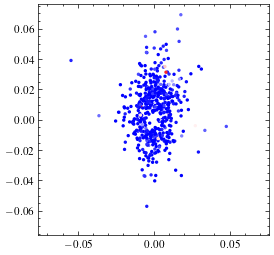

In [12]:
filters = get_filter(model, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F-2]*np.cos((theta[:,F-2]))).numpy()
y = (a_mag[:,F-2]*np.sin((theta[:,F-2]))).numpy()
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2_mean_act)

ax.scatter(x,y, c=color, cmap = 'bwr', s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

(3, 3, 512, 512)
(512,)


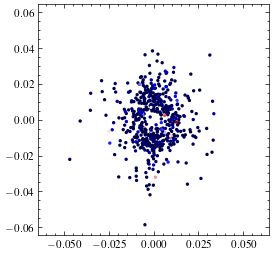

In [13]:
filters = get_filter(model, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2_mean_act)

ax.scatter(x,y, c=color, cmap = 'seismic', s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

In [14]:
def rotate (model_original, layers)  :
	model = tf.keras.models.clone_model(model_original)
	model.set_weights(model_original.get_weights())
	conv_layers = []
	for l in model.layers:
		if 'conv2d' in str(type(l)).lower():
			if l.kernel_size == (3,3) or l.kernel_size == (7,7):
				conv_layers.append(l)
				print(l)
	for l in layers:
		filters, biases = conv_layers[l].get_weights()
		print(conv_layers[l].name)
		# Reshape weights to (64 * 128, 3, 3) for batch processing
		k = filters.shape[0]
		weights_reshaped = tf.reshape(filters, (k, k,-1))

		rotated_weights = tf.image.rot90(weights_reshaped, k=2)
		rotated_weights = tf.reshape(rotated_weights, (k, k,filters.shape[-2],filters.shape[-1]))
		
		conv_layers[l].set_weights([rotated_weights, biases])


	return model


block1_conv2
block5_conv1


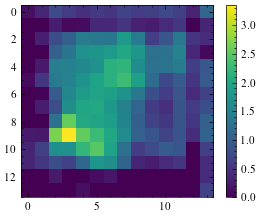

In [15]:
model_rot = rotate(model, [1])
'''model_rot.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=False),            
			metrics=[
				keras.metrics.CategoricalAccuracy(name="accuracy"),
				keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),])'''

origAMR, scaledAMR = getAM(model_rot, LAYER, F )
modified_model = keras.models.Model(
	model_rot.inputs, [model_rot.layers[layer_num_p].output, model_rot.layers[layer_num].output, model_rot.output]
)

f2R, f1R, predsR = modified_model(tf.expand_dims(origAM, axis=0), training=False)
f2R_mean_act = tf.math.reduce_mean(f2R, axis=(0,1,2))

plt.imshow(f1R[0,...,F])
plt.colorbar()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


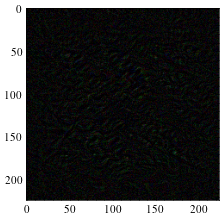

In [16]:
plt.imshow(origAM)

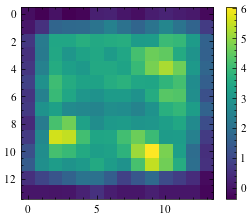

In [17]:
plt.imshow(f1[0,...,F]-f1R[0,...,F])
plt.colorbar()

(3, 3, 512, 512)
(512,)


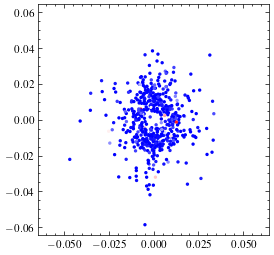

In [18]:
filters = get_filter(model, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2_mean_act)

ax.scatter(x,y, c=color, cmap = 'bwr', s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

(3, 3, 512, 512)
(512,)


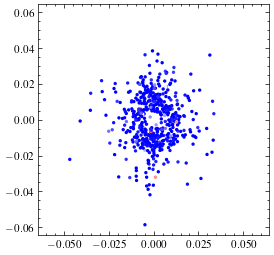

In [19]:
filters = get_filter(model_rot, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2R_mean_act)

ax.scatter(x,y, c=color, cmap = 'bwr', s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

In [20]:
topAct = tf.math.top_k(f2R_mean_act, k=10).indices.numpy()
topAct

array([ 30, 384, 267, 464, 273,   4, 318, 229, 235, 201])

(3, 3, 512, 512)
(512, 10)


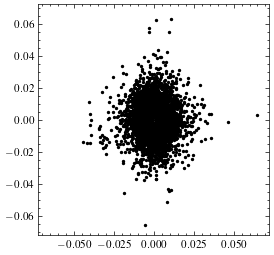

In [21]:
filters = get_filter(model, LAYER-1)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1]).numpy()
s_mag = reduce_euclidean_norm(s, axis=[0,1]).numpy()

x =(a_mag[:,topAct]*np.cos((theta[:,topAct])))
y = (a_mag[:,topAct]*np.sin((theta[:,topAct])))
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))

ax.scatter(x,y, s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

(array([2., 0., 0., 2., 3., 0., 1., 0., 1., 1.]),
 array([-2.94891   , -2.4199188 , -1.8909274 , -1.3619361 , -0.8329448 ,
        -0.30395353,  0.22503777,  0.75402904,  1.2830204 ,  1.8120116 ,
         2.341003  ], dtype=float32),
 <BarContainer object of 10 artists>)

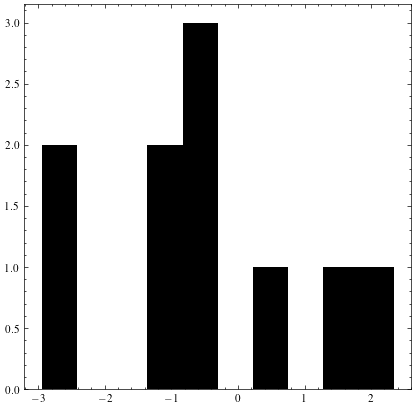

In [22]:
domOrr = getDominantAngle(get_filter(model, LAYER-1))[topAct]
kernOrr = getSobelTF(get_filter(model, LAYER))[topAct,F]
orrSim = domOrr - kernOrr  #orrientation similarity
orrSim  = np.arctan2(np.sin(orrSim), np.cos(orrSim))  #Wrap values -pi to pi
color =  matplotlib.colors.Normalize(vmin=-np.pi, vmax=np.pi)(orrSim)

fig,ax  = plt.subplots(1,1,figsize=(5,5))
dc = np.mean(filters, axis=(0,1))

ax.hist(orrSim)


C:\Users\AN46710\AppData\Roaming\Python\Python37\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


InvalidArgumentError: {{function_node __wrapped__GreaterEqual_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:GreaterEqual]

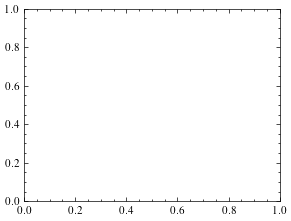

In [23]:
fig, ax= plt.subplots(1,1)

data = orrSim
 # (np.array(cos_sim) + np.pi) % (2 * np.pi) - np.pi
ax.hist2d(data,f2_mean_act, bins=8)#, weights=weight)
print(ax.get_xlim())
data_min, data_max = np.min(data), np.max(data)

# Set the tick marks at intervals of π
tick_min = np.floor(data_min / np.pi) * np.pi  # Start at the lowest multiple of π
tick_max = np.ceil(data_max / np.pi) * np.pi    # End at the highest multiple of π
ticks = np.arange(tick_min, tick_max + np.pi, np.pi)  # Ticks spaced by π
print(tick_min)
# Format tick labels with π notation
labels = [f"{int(t / np.pi)}π" if t != 0 else "0" for t in ticks]
labels = [label.replace("π", "$\\pi$").replace("1$\\pi$", "$\\pi$") for label in labels]
print(labels)
# Set ticks and labels on the x-axis
ax.set_xticks(ticks=ticks, labels=labels)




#ax.convert_xunits(radians)
ax.set_ylabel(r"$\cdot ||f||$ (scaled Min-Max)", fontsize=7)
#ax.set_ylabel(r"Count", fontsize=7)
ax.set_xlabel(r"$\mathbf{\theta}^{L}_{F[i, :]} - \hat{\theta}^{L-1}_{F[:, i]}$", fontsize=7)
ax.set_title(f"Layer {LAYER-1}"+r"$\rightarrow$"+f"{LAYER}")


plt.show() 

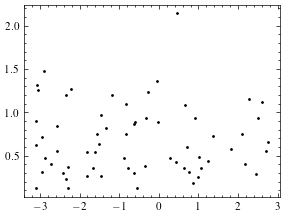

In [175]:
fig, ax= plt.subplots(1,1)

ax.scatter(orrSim, f2_mean_act, s=1)

(3, 3, 64, 64)
(36,)


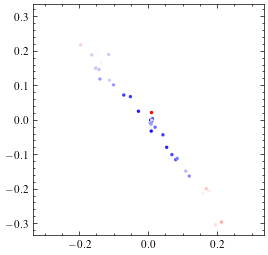

In [176]:
posChannels = tf.where(tf.greater(np.sign(dc[:,F]),0))[:,0].numpy()
posChannels
filters = get_filter(model, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()[posChannels]
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()[posChannels]
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2_mean_act.numpy()[posChannels])

ax.scatter(x,y, c=color, cmap = 'bwr', s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

(3, 3, 64, 64)
(64,)


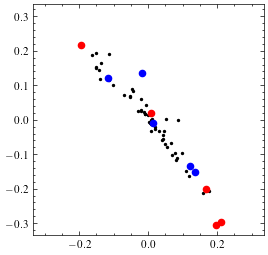

In [177]:
negChannels = tf.where(tf.less(np.sign(dc[:,F]),0))[:,0].numpy()
negChannels
filters = get_filter(model, LAYER)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

topAct = tf.argsort(f2_mean_act, direction='DESCENDING').numpy()#[:, top10F.indices.numpy()]
top10channels = topAct[np.isin( topAct, posChannels )]
top10channels = top10channels[:5]

x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()#[negChannels]
y = (a_mag[:,F]*np.sin((theta[:,F]))).numpy()#[negChannels]
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))
color =  matplotlib.colors.Normalize(vmin=0)(f2_mean_act.numpy())



ax.scatter(x,y, c='black', cmap = 'bwr', s=2)
ax.scatter(x[top10channels],y[top10channels], c='red', cmap = 'bwr', s=20)
top10channels = topAct[np.isin( topAct, negChannels )]
top10channels = top10channels[:5]
ax.scatter(x[top10channels],y[top10channels], c='blue', cmap = 'bwr', s=20)

ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)

(array([3., 5., 5., 5., 2., 5., 3., 3., 3., 2.]),
 array([ 31.65753,  79.92199, 128.18645, 176.45091, 224.71536, 272.97983,
        321.2443 , 369.50876, 417.7732 , 466.03766, 514.3021 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

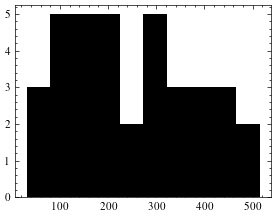

In [178]:
plt.hist(tf.math.reduce_euclidean_norm(f2, axis=(0,1,2)).numpy()[posChannels])

(array([5., 5., 7., 4., 1., 1., 2., 1., 0., 2.]),
 array([ 43.500538,  77.95901 , 112.41748 , 146.87595 , 181.33441 ,
        215.7929  , 250.25136 , 284.70984 , 319.1683  , 353.62677 ,
        388.08524 ], dtype=float32),
 <BarContainer object of 10 artists>)

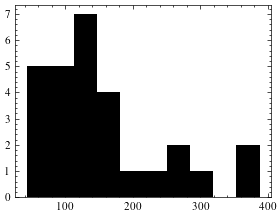

In [179]:
plt.hist(tf.math.reduce_euclidean_norm(f2, axis=(0,1,2)).numpy()[negChannels])

In [180]:
topAct = tf.argsort(f2_mean_act, direction='DESCENDING').numpy()#[:, top10F.indices.numpy()]
topAct[np.isin( topAct, posChannels )]

array([31,  0,  3, 47, 10, 51, 21, 37, 23, 35, 59, 34, 14, 28, 60, 53, 20,
       12, 25, 30, 32, 58, 63, 38, 27, 17, 16, 36,  4, 33,  9, 55,  2, 39,
       40,  1])

In [181]:
topAct[np.isin( topAct, negChannels )]

array([41, 61, 43, 45, 26, 57, 62, 29,  5,  8, 54, 49, 48, 18,  7, 46, 56,
       11, 15, 52, 42, 22, 44, 50, 13, 19, 24,  6])

In [182]:
plt.imshow(f2[0,..., 226])

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 226 of dimension 3 out of bounds. [Op:StridedSlice] name: strided_slice/

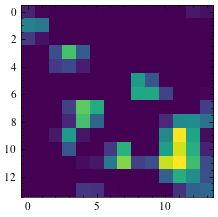

In [ ]:
plt.imshow(f2[0,..., 189])

(3, 3, 512, 512)
(512,)


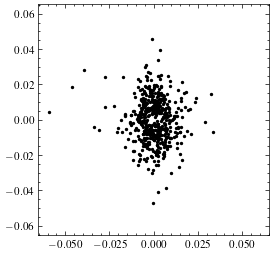

In [ ]:
F_p = topAct[np.isin( topAct, posChannels )][-1]
filters = get_filter(model, LAYER-1)  #[:,:,:, top10F.indices.numpy()]
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

x =(a_mag[:,F_p]*np.cos((theta[:,F_p]))).numpy()
y = (a_mag[:,F_p]*np.sin((theta[:,F_p]))).numpy()
print(x.shape)
lim_x = np.max(np.abs(x))
lim_y = np.max(np.abs(y))
lim = np.max([lim_x, lim_y])
#lim =np.max(np.abs(mag[:, i]))    
lim*= 1.1
fig,ax  = plt.subplots(1,1,figsize=(10,3))

ax.scatter(x,y , s=2)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_box_aspect(1)